# Pytorch Deep-Learning | Multi-Node / Multi-GPU | Docker 

***

In diesem Notebook wird PyTorch DDP verwendet, um das Trainieren auf einem Dask-Cluster zu skalieren. 

Von Pytorch selber gibt es euch einige Anwendungsbeispiele für Deep-Learning.
Saturncloud stellt uns Module bereit, einer dieser Module nennt sich Dask-PyTorch-DDP, was wir für das Trainieren mit Dask nutzen werden. <br>Ob Docker oder nicht, es muss ein Dask-Cluster erstellt werden, damit das mit Dask und PyTorch funktioniert. Die Worker sollten auf die GPU zugreifen können. 


Das verteilte Trainieren erfolgt so, dass wir unser Model als DDP-Model wrappen und mittels Dask auf die Worker verteilen. Das Verteilen findet im Hintergrund statt.

<u>Wann sollte PyTorch DDP genutzt werden:</u><br>
- Das Model passt auf eine GPU
- Es gibt sehr viele Trainingsdaten.<br>
DDP beschleunigt das Training, indem jeder erstellte Worker das gleiche Model mit unterschiedlichen Daten trainiert.


<br>

Dask und Dask.distributed sollten die gleiche Version haben. <br>
Dask: https://www.dask.org && https://docs.dask.org/en/stable/ <br>
PyTorch: https://pytorch.org  <br>
PyTorch releases: https://github.com/pytorch/pytorch/releases <br>
Dask-PyTorch-DDP Open Source Module von Saturncloud: https://github.com/saturncloud/dask-pytorch-ddp/tree/main <br>
PyTorch DDP "WHAT IS DISTRIBUTED DATA PARALLEL (DDP)" https://pytorch.org/tutorials/beginner/ddp_series_theory.html


# 1. PyTorch und Dask

Um die Verwendung von PyTorch DDP und den erstellten Modulen zu veranschaulichen, wird das PyTorch Basic Tutorial für den Basisfall genutzt. <br>
Daraufhin können  Anpassungen gemacht werden.


Die Netzwerke und Trainingsloops ändern sich für das Verteilte Trainieren  mit DDP nicht groß. Die Trainingsfunktion wird von jedem Worker ausgeführt. Ein Worker entspricht einer GPU mit genau einem Prozess. 

<br>

PyTorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html<br>
<p style="font-size:13px;">Bilder aus dem Tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html </p>

<div>
    <p style="float: left;"><img src="./pictures/pytorch_cnn_1.PNG" border="1px;" width="425px;" hight="425px;" ></p>
    <p style="float: left;"><img src="./pictures/pytorch_cnn_2.PNG" border="1px;" width="425px;" hight="425px;"></p>   <br>
</div>

Wir teilen das Training in 4 Bereiche auf. Hier nutzen wir MNSG.


<img src="./pictures/rapids_flynn.PNG"  width="625px;" hight="625px;">


<u>PyTorch DDP kurz erklärt</u>

DDP steht für Distributed Data Parallel. Nehmen wir an das wir 3 Nodes haben, mit je 1 GPU. PyTorch DDP startet 1 Prozess pro GPU, also haben wir am Ende 3 Prozesse. Ein Prozess nutzt ein CPU-Kern. Das Data Parallel entsteht dadurch, dass die Trainingsdaten parallel in die Netze gefüttert werden. Jeder Worker kann die lokalen Daten nutzen, in der Trainingsfunktion die jeder Worker ausführt, kann definiert werden wie Daten geladen werden.

Wenn nur der Host die Daten hat, müssen diese mit dem Cluster geteilt werden.


Die Abbildung unten zeigt 3 Nodes mit jeweils 1 GPU. Jede GPU hat eine Kopie des Models. Zum Trainieren werden die lokalen Daten geladen. Wie Daten geladen werden, ist den Benutzern überlassen. 


<img src="./pictures/5_DDP.PNG"  width="925px;" hight="725px;">
<!--</center>-->

Da wir die Trainingsdaten aufteilen, bekommt jedes Model einen anderen Input. Wenn das Netz auf eine GPU gut passt, wird das Model einfach auf die GPUs kopiert. Jeder Worker hat dann das gleiche Model zu Beginn, sowie Optimierer, usw. als wäre man nur auf einer lokalen Maschine.

Passt ein Model nicht auf eine GPU, so muss das Model aufgeteilt werden => Model Parallel <br>
Das ist in einem anderem Notebook beschrieben.

Die Synchronisation erfolgt mittels eines bucketed Ring All-Reduce Algorithmus. Die Layers des Models werden in sogenannten Buckets organisiert. 


Bild aus dem <a href="https://www.youtube.com/watch?v=3XUG7cjte2U">Erklärvideo:</a> <br>                         
<img src="./pictures/3_DDP.png" width="425px;" hight="550px;">
<img src="./pictures/4_DDP.PNG" width="425px;" hight="550px;">

PyTorch kümmert sich dann um den Rest.



<br>

Ring All-Reduce: https://tech.preferred.jp/en/blog/technologies-behind-distributed-deep-learning-allreduce/<br>
PyTorch DDP "GETTING STARTED WITH DISTRIBUTED DATA PARALLEL": https://pytorch.org/tutorials/intermediate/ddp_tutorial.html <br>
PyTorch DDP Erklärvideo (von PyTorch YouTube): https://www.youtube.com/watch?v=Cvdhwx-OBBo&list=PL_lsbAsL_o2CSuhUhJIiW0IkdT5C2wGWj&index=2  <br>


# 2. Aufbau und Möglichkeiten 

Wir importieren Dateien, die Klassen und Funktion erhalten, um die Benutzung zu vereinfachen.

In den Modulen selber können Einstellungen vorgenommen werden. Wenn PYTORCH_MODULE_LOG auf False gesetzt wird, werden keine Informationen ausgegeben.

In [1]:
## Tools um die Nutzung zu vereinfache
# - Das Modul selber imortiert auch pytorch_dispatcher_resulthandler
import pytorch_tools as pytorch_tools

Tools 1.0 | Setze Umgebungsvariablen
PYTORCH_DIST_BACKEND: nccl
PYTORCH_DIST_DDP_PORT: 23456
NCCL_SOCKET_NTHREADS: 4
NCCL_NSOCKS_PERTHREAD: 2
PYTORCH_MODULE_LOG: True

RPC Config:
GLOO_SOCKET_IFNAME: eno1, NCCL_SOCKET_IFNAME: eno1
TP_SOCKET_IFNAME: eno1    , START_ON_RANK: 0
PyTorch Dispatcher-/Resulthandler 1.0


In [2]:
# Code für PyTorch DDP
import pytorch_dispatcher_resulthandler

In [3]:
# Erstelle Client 
client = pytorch_tools.create_dask_client()  # Gebe IP an. Standart:  127.0.0.1:8786 (Scheduler ist da wo auch Jupyter läuft)
client

Client-IP: 127.0.0.1:8786


<Client: 'tcp://149.201.182.203:8786' processes=2 threads=2, memory=125.06 GiB>

Das Modul enhält Klassen, Funktionen und setzt Umbegungsvariablen, die auch andere Worker sehen müssen. Damit das kappt, muss das Modul im Cluster hochgeladen werden. <br> 

Wenn die Module verändert werden, müssen diese erneut hochgeladen werden. Beim Erstellen des Clients mit "pytorch_tools.create_dask_client()" wird die Funktion "scatter_files()" aufgerufen, das diese Module hochlädt.

In [4]:
## So werden die Module pytorch_tools.py und pytorch_dispatcher_resulthandler.py mit dem Cluster geteilt. 
#  *Bei Änderungen muss der Kernel in Jupyter neugestartet werden. 
pytorch_tools.scatter_files(client) 

Wenn wir eigene Module erstellen, können wir diese auch mit dem Cluster teilen. 

In [5]:
# Zeige Schlüssel. Die Ports ändern sich. 
client.has_what().keys()

dict_keys(['tcp://149.201.182.188:44333', 'tcp://149.201.182.205:45123'])

In [144]:
# Starte alle Worker neu
client.restart_workers( client.has_what().keys() )
client.has_what().keys()

dict_keys(['tcp://149.201.182.188:46327', 'tcp://149.201.182.203:45273', 'tcp://149.201.182.205:32919'])

In [104]:
# Startet client neu.
#client.restart()

Das Setup mit Docker kann so aussehen. Es gibt eine Node die Scheduler ist. Diese Node kann auch einen Worker haben. 

Wenn der Scheduler auch worker sein soll, muss eine zweite Konsole geöffnet werden, um den Worker zu starten. Wer am Ende Scheduler ist, ist egal, alle Knote sind gleichberechtigt.

Beispiel Setup (auf Node1 läuft auch Jupyter).: <br>
<img src="pictures/cluster_setup.PNG" width="925px;" hight="850px;"><br>
Docker logo:<br>
https://www.docker.com/company/newsroom/media-resources/![cluster_setup.png](attachment:9a543a66-02b7-4661-a8f9-a9be164d0575.png)

Das untere Bild zeigt, wie die Aufteilung von Client, Worker und Scheduler sein könnten. Nachrichten und das Model selber werden an den Client geschickt, da von dort aus die Traningsfunktion mit Dask an die Worker submitet wird. Der Resulthandler der sich auf dem Client befindet, sammelt die Nachrichten. 

<img src="./pictures/cluster_aufbau.PNG" width="725px;" hight="850px;" >

Als Erstes kommen die Importe, was fehlt, kann dazugenommen werden. Alle Knoten (falls Cluster) sollten dieselben Pakete installiert haben, möglichst mit derselben Version.

In [1]:
# Imports die wir benötigen
###########################################################################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import torchvision
from torch.utils.data.distributed import DistributedSampler
import torchvision.transforms as transforms

from dask.distributed import Client
import dask

import time
import sys
import os
import datetime
import pickle

import numpy as np
import torch.distributed as dist
from distributed.pubsub import Pub, Sub


Was passiert im Hintergrund?<br>
Es wird pro Worker eine Funktion submitet. Diese Funktion ist unsere Trainingsfunktion. Jeder Worker führt das Training aus und nutzt die eigenen Daten. Wenn Daten lokal geladen werden, werden keine Daten über das Netzwerk geteilt. Wie Daten geladen werden, ist ganz dem Benutzer überlassen.

<u>Hinweis:</u><br>
Bei `run()` sollte ein freier Port angegeben werden, eingestellt ist <u>23456</u>. Siehe pytorch_dispatcher_resulthandler.py

Vereinfacht würde das so aussehen:

<img  src="./pictures/dispatcher_flow.PNG" width="1100px;" hight="900px;">

Jeder Worker kann Nachrichten ausgeben. Es wird ein Channel erstellen, mit einem Subscriber und mehreren Publishern (die Worker). Der Host (z.B. Jupyter) bekommt die Nachrichten. Sobald was auf den Channel gelegt wird, liest der Subscriber diese Daten. 


<br>
<p style="float: left;"><img src="./pictures/pubsub2.PNG" width="625px;" hight="750px;" ><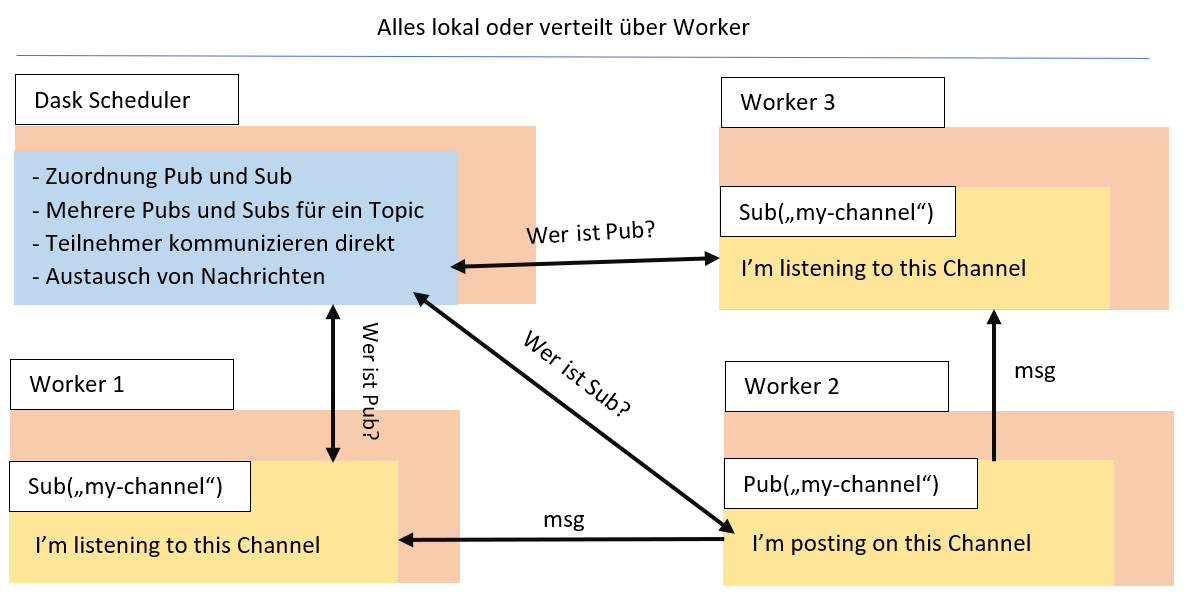/p>
<p style="float: left;"><img src="./pictures/pubsub3.PNG" width="625px;" hight="750px;"></p>

## 2.2 Netzwerke

Es gibt verschiedene Netzwerke und Wege diese zu erstellen. Bei DDP wird das Netzwerke auf allen Knoten kopiert und dann mit den Trainingsdaten versorgt. Das klappt gut, wenn das Netzwerk auf eine GPU passt. 

Ist das Netzwerk zu groß für eine GPU, können die Layers auf die GPUs aufgeteilt werden => Model Parallel. 
Zu Model Parallel gibt es ein separates Notebook.


Bei der Struktur der Netzwerke muss hauptsächlich darauf geachtet werden, dass bestimmte Teile explizit auf die GPU geschoben werden.

So könnten Netzwerke aussehen:


In [6]:
#############################              
###  Beispiel Netzwerke die man bei DDP nutzen könnte.
#############################

# CNN | PyTorch Basic Tutorial | https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
# RNN | https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/#3-building-a-recurrent-neural-network-with-pytorch-gpu
class Model_2(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Model_2, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)                                 # Hier:  to(device)

        # One time step
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100 
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    

# LSTM | https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ 
# - Mit CSV Datei einlesen
class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    
    
# LSTM | https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/#model-c-3-hidden-layer
class Model_4(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Model_4, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros                                       
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()                # Hier: device=x.device  oder .to(device), siehe RNN

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()                # Hier: device=x.device  oder .to(device), siehe RNN

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
# Autencoder | https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/
class Model_5(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Diese Netzwerke sind Beispiele, wie sowas aussehen könnte. Bei den RNN und LSTM Modellen ist zu beachten, dass man bei forward() h0, c0, ..., auf die GPU packt mittels `.to(device)` oder mit `device=x.device`. Wenn man es nicht macht, kommt ein Fehler, dass Teile auf der GPU und CPU sind. Falls so ein Fehler auftaucht, wird normalerweise gesagt, wo und woran es liegt. 

## 2.3 Trainingsroutine


Wir betrachten wir den Fall, dass wir ein Docker Cluster Setup haben. PyTorch DDP kann mit 1 Worker gut umgehen, will man mehrere, startet man mehrer Worker. Man selber muss sich keine Gedanken um das Skalieren machen.


Die <u>Batchgröße</u> kann die Geschwindigkeit und Qualität des Trainings beeinflussen. 

Im Folgendem könne wir auch ein <u>DDP Hook nutzen</u>. Der Hook hier heißt PowerSGD Hook. Es komprimiert die Kommunikation und ist geeignet wenn die Netzwerkkommunikation ein Bottleneck ist, besonders wenn das Model groß ist. Eine umfassende Beschreibung find man in dem Paper. Bei kleineren Modellen kann es zu keinem Unterschied kommen, man kann es trotzdem ausprobieren.

Der PowerSGD Hook hat 2 Wichtige Parameter:<br>
`matrix_approximation_rank:int` Kompressionsrate, ein hoher Wert kann die Berechnungskosten der Kompression steigern. Starte bei 1 und erhöhe immer um 2.  <br>
`start_powerSGD_iter:int` Warte bis zum Schritt n, dann führe ein All Reduce der vorherigen Schritte durch. Vorgeschlagen wird ein Wert <br>
der Größe 10% der gesamten Trainingsschritte. 

Der Zweck des Hooks ist es, die Kommunikation beim verteilten Trainieren zu verbessern. <br>
Es gibt noch weitere Hooks: fp16_compress_hook(), bf16_compress_hook() und batched_powerSGD_hook(). Momentan wird hier nur der PowerSGD und fp16_compress_hook Hook angeboten. <br>
Die Hooks für bf16 brauchen eine NCCL Version > 2.9.6


<u>Was wir zusätzlich nutzen können:</u> <br>
Distributed Optimizer, die die Kommunikation und Optimierung beeinflussen. Siehe (https://pytorch.org/docs/main/distributed.optim.html#torch.distributed.optim.DistributedOptimizer) <br>
DDP Hooks, um die Kommunikation mit DDP zu beeinflussen. Siehe (https://pytorch.org/docs/stable/ddp_comm_hooks.html)<br>
BF/FP16 Format statt float32, kann die Berechnungskosten senken. Zur Anwendung siehe hier (https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html#default-precision)

Alle drei haben <u>Einfluss</u> auf die Trainingszeit und die Genauigkeit des Models. Der Optimierer und Hooks sind im Modul enthalten und können einfach eingesetzt werden.

Anwendung von:<br>
Distributed Optimizer: PostLocalSGDOpt mit `model, optimizer = pytorch_tools.register_distOpt_PostLocalSGDOpt(model, device_id, optimizer, period=4, warm_up:int=100)`.  <br>
Hook PowerSGD: `model = pytorch_tools.register_DDP_PowerSGD_hook(model, device_id, matrix_approximation_rank:int=12, start_powerSGD_iter:int=2)`. <br>
Hook PowerSGD fp16: `model = pytorch_tools.register_fp16_compress_wrapper_SgdPower_hook(model, device_id, matrix_approximation_rank:int=12, start_powerSGD_iter:int=2):`


Der Optimierer PostLocalSGDOpt läuft auf jedem Worker. <br>
`period` gibt an, dass alle 4 Schritte Global gemittelt wird. `warm_up` gibt an, dass die ersten 100 Schritte die Gradienten lokal gemittelt werden.

Das untere Beispiel zeigt, wie ein Training aussehen könnte. Wir nutzen dafür das Model aus dem Basic PyTorch Tutorial und das Cifar10 Dataset, was jeder Worker aus dem Internet lädt.

Wenn dieser Ablauf funktioniert, sollte es keine Probleme mit dem verteilten Trainieren geben. Man kann so den <u>Aufbau testen</u>, sowie Dask und den Cluster.

<br>


DDP Hook:<br>
https://pytorch.org/docs/stable/ddp_comm_hooks.html <br>
- Science Paper: https://arxiv.org/pdf/1905.13727.pdf
- Accelerating PyTorch DDP by 10X With PowerSGD (Von PyTorch): https://medium.com/pytorch/accelerating-pytorch-ddp-by-10x-with-powersgd-585aef12881d
- Verfügbare PyTorch Hooks: https://medium.com/analytics-vidhya/pytorch-hooks-5909c7636fb

Distributed Optimizer:<br>
- post-local SGD https://pytorch.org/docs/main/distributed.optim.html#torch.distributed.optim.PostLocalSGDOptimizer  Paper: https://arxiv.org/abs/1808.07217

<u>Hinweis:</u><br>
Wenn es hängt oder bei Problemen: Worker/Notebook/Cluster, ... neustarten.<br>
Das kann manchmal helfen. Das Problem kann auftauchen, wenn Exceptions vorkommen. 

Die Registrierung eines Hooks mit "register_comm_hook" kann nur einmal stattfinden (passiert im Hintergrund). Das bedeutet, dass das entweder PowerSGD oder ein Distributed Optimizer genutzt werden kann, beides geht nicht. 

Wenn man beides nutzt, wird eine Exception geworfen: "Exception: "RuntimeError('register_comm_hook or register_builtin_comm_hook can only be called once.')""<br>


<u>Hinweis zum Dataloader:</u><br>
Um die Parameter num_workers und prefetch_factor zu nutzen, muss unter Dask eingestellt werden, dass die Worker nicht als Daemon Prozesse starten. Diese Parameter können die Trainingszeit verkürzen. <br>
`num_workers:int` Erstelle n-Prozesse zum laden der Daten. <br>
`prefetch_factor:int` Lade n-Batches vor. 

Damit das funktioniert, muss <u>vor</u> dem start der Worker eine Umgebungsvariable gesetzt werden. Bei jedem Worker muss es gesetzt sein. <br>
Setze: `DASK_DISTRIBUTED__WORKER__DAEMON=False`. Der Standartwert ist `True`.


Eine Abfrage kann so gemacht werden:<br>
`dask.config.get("distributed.worker.daemon")`. 


<br>


Setzen und abfragen von Einstellungen in Dask: https://docs.dask.org/en/latest/configuration.html#conversion-utility



In [7]:
## Trainingsfunktion die jeder Worker ausführt. 

def train():
    
    pub_stats  = Pub("my_channel")                          # Channel für Nachrichten              
    worker_rank = int(dist.get_rank())                      # Globaler Rank
    worker_ip = os.getenv('WORKER_HOST')                    # Worker IP
    device_id = worker_rank % torch.cuda.device_count()
    
    device = torch.device("cuda")  # 'cuda': Nutze alle GPUs | 0: nutze GPU 0 | 'cpu': Nutze CPU, Backend auf gloo stellen | "cuda" if torch.cuda.is_available() else "cpu")
    
    """Edits: 
    num_epochs: Epochen
    batch_size: Batchgröße 
      - Die Auswahl von batch_size kann die Trainingszeit und Genauigkeit beeinflussen.
    transform: Transformiere Bilddaten
    trainset: Erstellt ein PyTorch Dataset. 
      - Wie man eigene Datasets erstellt findet, man weiter unten. 
    sampler: Nutze Sampler, wenn alle Daten auf allen Knoten gleich sind, und sich nicht unterscheiden.
      - Hier hat jeder das Cifar10 Dataset, der Sampler sorgt für die gleichmäßige Aufteilung. 
    """
    num_epochs = 5     # Change
    batch_size = 16    # Change  

    transform = transforms.Compose( [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform) # Das Dataset liegt bei jedem Worker in ./data
    # PyTorch DistributedSampler:
    # - Wenn alle Daten gleich sind, sorgt der DistributedSampler für die Aufteilung dieser Daten.
    sampler = DistributedSampler(trainset)
    # Beim Dataloader kann num_workers und prefetch_factor übergeben werden. In Dask bevor die Worker starten: export DASK_DISTRIBUTED__WORKER__DAEMON=False
    loader = DataLoader(trainset, batch_size=batch_size, sampler=sampler, num_workers=2, prefetch_factor=4, pin_memory=True ) #num_workers=2, prefetch_factor=1, pin_memory=True
    
    
    # the model has to both be passed to the GPU device, then has to be wrapped in DDP so it can communicate with the other workers
    model = Model().to(device) 
    # Model direkt in DDP umwandeln.  
    model = DDP(model,  device_ids=[device_id]) 
    
    ##  - Nutze Hook: - ##
    # - Paramater: model, device_id, matrix_approximation_rank:int=12, start_powerSGD_iter:int=2
    #model = pytorch_tools.register_DDP_PowerSGD_hook(model, device_id)   # SGD Hook, Model wird dort auch in DDP umgewandelt.  


    # Edits:
    # - optimizer und criterion laufen Lokal auf jedem Worker. 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    ## - Kann einen verteilten Optimierer nutzen. Dann aber keinen anderen Hook. - ##
    # - register_distOpt_PostLocalSGDOpt(model,  device_id, local_optim, period:int=4, warm_up:int=100)
    #model, optimizer = pytorch_tools.register_distOpt_PostLocalSGDOpt(model, device_id, optimizer)
    
    for epoch in range(num_epochs):
        
        # this ensures the data is reshuffled each epoch, if using sampler. 
        sampler.set_epoch(epoch)
         
        correct = 0
        for i, (batch_x, batch_y) in enumerate(loader):
        
            optimizer.zero_grad()
            # Verschiebe X, y auf GPU
            outputs = model(batch_x.to(device))                     # Oder vorher:  batch_x = batch_x.to(device)    batch_y = batch_y.to(device)  
            loss = criterion(outputs, batch_y.to(device))
            
            # PyTorch DDP Gradient AllReduce
            loss.backward()
            # Update weights
            optimizer.step()   
            
            """ Schreibe Nachricht   
            if worker_rank == 0:  # Worker x 
                msg = "..."  # loss.item(), ...
                pub_stats.put({"msg": msg})  # Wird in Jupyter angezeigt, Dict wird ausgegeben.  
            """

           #  Während des Trainierens können verschiedene Werte berechnet werden, wie die accuracy.
        
            _, predicted = torch.max(outputs.data, 1)
            if torch.cuda.is_available():
                correct += (predicted.cpu() == batch_y.cpu()).sum()
            else:
                correct += (predicted == batch_y).sum()
        accuracy = 100 * correct / len(trainset)

        
        # Worker 0 soll Model senden und gibt Nachricht aus.
        if worker_rank == 0: # jede Epoche

            msg = f"loss: {round(loss.item(), 4)} acc: {accuracy}  epoche: ({epoch+1}/{num_epochs})"
            pub_stats.put({"msg": msg})
            
            ## Model als Dict, Pfad, **kwargs wie epoch=epoch
            # - pytorch_tools.ddp_save_model_dict(channel, model_dict, path, **kwargs)
            pytorch_tools.ddp_save_model_dict(pub_stats, model.state_dict(), "./DDPmodel", epoch=epoch)
            # ** Oder auch: model.module.state_dict() 
            #    - Dann muss beim Laden das Model nicht als "torch.nn.DataParallel( Model() )" gewrapped werden.  
                    

Das Model wird als Dict gespeichert. Beim Speichern können noch weitere Daten mitgegeben werden, die beim späteren Laden dann verfügbar sind. <br>
Das Dict mappt die zugehörigen Layers des Models zu den Parametern. Nicht das ganze Model wird gespeichet. 

Mit `pytorch_tools.ddp_save_model_dict(pub_stats, model.state_dict(), "./DDPmodel")` wird das Model gespeichert und enthält die Endung `.pt`. <br>
Es werden nur die Trainierten Parameter gespeichert. 

Werden weitere Parameter wie Epoche übergeben, wird ein Checkpoint mit der Endung `.ckpt` erstellt.  So könnte das Speichern aussehen: <br>
`pytorch_tools.ddp_save_model_dict(pub_stats, model.state_dict(), "./DDPmodel", epoch=epoch, optimizer_state_dict=optimizer.state_dict() )`.

Mit diesen oberen zwei Methoden kann das Model als Dict über das Netzwerk gesendet werden, damit der Client die Resultate bekommt. <br>
Anders sieht es aus, wenn das ganze Model verschickt werden soll, da gibt es bei der Serialisierung Probleme. <br>
Momentan kann das Model nur als Dict gespeichert werden. 


<br>
Mehr Informationen über das Speichern und Laden in PyTorch: <br> 

What is a state_dict?: https://pytorch.org/tutorials/beginner/saving_loading_models.html#what-is-a-state-dict  <br>
Saving & Loading Model for Inference (Endung .pt oder .pth): https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference <br>
Export/Load Model in TorchScript Format:  https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format <br>
Saving & Loading a General Checkpoint for Inference and/or Resuming Training (Endung ckpt.): https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training

In [8]:
# Am Ende wird die Systemzeit ausgegeben. Die Stunden können abweichen. Mit date_time_hour_offset kann es angepasst werden. Rechne zur Uhrzeit +/- n-Stunden.
# - pytorch_tools.run(train, client, date_time_hour_offset:int=0 )  Zeitformat:  Tag-Monat-Jahr  Stunde-Minute-Sekunde
pytorch_tools.run(train, client) 

Worker count: 2
Start training

loss: 2.0959 acc: 9.043999671936035  epoche: (1/5)
loss: 1.5769 acc: 17.36199951171875  epoche: (2/5)
loss: 1.343 acc: 21.17799949645996  epoche: (3/5)
loss: 1.2019 acc: 23.350000381469727  epoche: (4/5)
loss: 1.5007 acc: 25.110000610351562  epoche: (5/5)
Time elapsed: 56.15068078041077
16.11.2023  17:40:19 



Die Trainingsfunktion kann auch Parameter annehmen, um pro Worker bestimmte Entscheidungen zu treffen, wie das Laden verschiedener Daten aus verschiedenen Verzeichnissen.

Das Beispiel unten wird das Vorgehen erläutern. 

Diese Methoden zeigt, wie das Modul die Informationen erfasst, die dann für die Verteilung genutzt werden.<br>
Jeder Worker führt auch ein Print aus indem IP, Rang und lokaler Rang ausgegeben werden. 

In [9]:
# Aufteilung der Worker
pytorch_tools.listDaskWorker(client)

[{'worker': 'tcp://149.201.182.188:45851',
  'local_rank': 0,
  'global_rank': 0,
  'host': '149.201.182.188'},
 {'worker': 'tcp://149.201.182.203:42399',
  'local_rank': 0,
  'global_rank': 1,
  'host': '149.201.182.203'}]

Jeder Worker kann durch einen Rank erkannt werden. Durch Abfragen in der Trainingsfunktion von IP und anderen Informationen z.B. mittels Python, kann jeder <br>
Worker bestimmte Aufgaben erledigen. Als Beispiel soll jeder Worker mit seiner IP eine Liste auswählen. Bei mehreren Workern mit gleicher IP müssen mehr <br>
Erkenungsmerkmale wie Port oder Rang genutzt werden.

In [10]:
## Unterteile Daten als Dict oder anders.
# Jeder Worker mit IP soll eine bestimmte Liste bekommen. Jeder Worker bekommt diese Parameter. 
shared_info = {'worker_data': { '149.201.182.203': [1,2,3,4], '149.201.182.188': [5,6,7,8] } }                    

In [11]:
# Parameter task
def train_test(task):
    pub_stats   = Pub("my_channel")                
    worker_rank = int(dist.get_rank())                  # Globaler Rank
    worker_ip   = os.getenv('WORKER_HOST')              # Worker IP
    # Mit Python können auch andere Merkmale wie Hostname ermittelt werden. 
    
    time.sleep(2)
    data = task['worker_data'][worker_ip]
    msg = f"I'm worker {worker_ip} and my list is {data}"
   
    pub_stats.put({"msg": msg}) 
    

In [12]:
pytorch_tools.run(train_test, client, task=shared_info) 

Worker count: 2
Start training

I'm worker 149.201.182.203 and my list is [1, 2, 3, 4]
I'm worker 149.201.182.188 and my list is [5, 6, 7, 8]
Time elapsed: 5.042824745178223
16.11.2023  17:40:45 



### 2.3.2 Evaluieren in der Trainingsloop

Bei dem Trainieren kann man neben dem normalen Vorgehen auch das Model gleichzeitig evaluieren, dazu muss man auch einiges beachten. Eines der wichtigen Dinge ist, dass bestimmte Teile auf der GPU und andere auf der CPU sein müssen, damit das Evaluieren gut geht, sonst tauchen Fehler auf.

Das folgende Beispiele zeigt eine Trainingsschleife, wo auch die Genauigkeit getestet wird. Aufkommende Fehlern weisen auf die Bereiche hin, es kann vorkommen das manche Fehlermeldungen nicht sehr aussagekräftig sind, meist findet man auf GitHub und andere Webseiten Lösungen dazu.

# 3. Details zu den Datasets und Dataloaders

Das PyTorch Dataset ermöglicht das einfache Umgehen  mit den Daten. Die Funktion braucht 3 Methoden: `__init__`, `__len__` und `__getitem__`. In der init Methode kann man z.B. die Daten nochmal verändern oder von dort aus laden. 

Ohne ein Dataset können Daten so direkt geladen werden: `Train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)`.<br>
Es ist leicht und schnell erledigt. Man kann auch ein eigenes PyTorch Dataset erstellen. Beispiele dazu folgen.

Der Dataloader wird beim Training genutzt und hat Zugriff auf das Dataset.


<br>

PyTorch Dataset und Dataloader: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#loading-a-dataset  <br>
PyTorch Dataloader https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler

Das Laden und Verarbeiten der Daten kann als Funktion ausgelagert werden. Dort (oder im Dataset) kann vom HDFs gelesen werden.<br>

<u>Hinweis:</u><br>
Wenn es zu einem Pickelerror kommt, müssen bestimmte Klassen und Funktionen in eine .py Datei geschrieben und von jedem Worker importiert werde. <br>
Dateien können mit `client.upload_file('myfile.py')` hochgeladen werden.

## 3.1 Eigenes PyTorch Dataset

Wenn wir Bilder aus dem HDFS laden wollen, müssen wir eine Funktion nutzen. Derzeit können wir den Vorteil der Datenlokalität nicht nutzen, siehe (https://dask.discourse.group/t/reading-data-and-image-data-from-hdfs-for-training/2220/2).



Das Beispiel zeigt, wie man derzeit Bilddaten aus dem HDFs laden könnte. 

Als erstes listen wir alle Pfade auf, danach laden wir die Bilder. 

In [26]:
# Liste alle Pfade der Bilder auf.
def get_filenames(fs): 
    
    classes =['dog', 'chicken']   # Klassen dir wir haben (und auch verzeichnisse) 
    data = []
    file_location = []
    # HDFs verbindung
    hdfs = fs.HadoopFileSystem("hdfs://sun.bigdata.fh-aachen.de", port=9000, user="schechtel")
        
    for i in classes:
        files = hdfs.get_file_info(fs.FileSelector(f'/project/schechtel/animals/{i}')) # Pro Verzechniss werden alle Pfade aufgelistet. 
        print(f"Class: {i} \t items: {len(files)}")
        for path in files:
            data.append([path.path, i])  # Data: [...PNG , Klasse Dog]
            
    np.random.shuffle(data) # Shuffle

    return data

In [20]:
import skimage

# Dataset
class create_trainset(Dataset):
    def __init__(self, data_paths):  
        """
        data_paths: Die Pfade die mit get_filenames ermittelt wurde.
        - Könnte auch hier gemacht werden... 
        """
        self.data_paths = data_paths  # Data: [...PNG , Klasse Dog]
        self.hdfs = fs.HadoopFileSystem("hdfs://sun.bigdata.fh-aachen.de", port=9000, user="schechtel")  # HDFS  Verbindung 
        # Sonstige Angaben... 
        self.img_dim    = (32, 32) # 227
        self.transform = transforms.Compose(
                           [transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] )
        self.class_map = {'dog':0, 'chicken': 1}
          
    def __len__(self):
        return len(self.data_paths)  # Länge des Datasets 

    def __getitem__(self, idx):      # Iteriere mit idx:   __getitem__(idx)
         
        img_path, class_name = self.data_paths[idx]    # img_path=...PNG,  class_name=... dog

        loded_image = skimage.io.imread( self.hdfs.open_input_file(img_path) )
        img = Image.fromarray(np.uint8(loded_image)) 
        img = fn.center_crop(img, self.img_dim) 
        img = self.transform(img) 
        
        class_id = self.class_map[class_name]   # dog => 0
        
        img_tensor = torch.from_numpy(np.asarray(img).copy())
        
        class_id = torch.tensor([class_id]) 

        return img_tensor, class_id 
        

Wenn die Daten lokal auf dem Rechner sind, könnte das Laden der Daten so aussehen wie unten. <br>
Im Dataset ermitteln wir mittels Python alle Bildnamen und Pfade.

Im Dataset können auch Subsets von Pfaden für veschiedene Worker erstellt werden, oder auch Datasets für das Testen. 

In [13]:
%%writefile mask_dataset_func.py
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
from PIL import Image
import skimage
import torch
import numpy as np
import os
class mask_dataset(Dataset):
    def __init__(self):
        self.classes=['with_mask','without_mask']             # 2 Klassen
        self.class_map={'with_mask':0, 'without_mask':1 }
        self.dir="01work/Datasets/facemask/archive/"          # ../archive/with_mask  |  ../archive/without_mask  
        self.img_paths=[]
        
        for klass in self.classes:
            tmp_list = os.listdir(f"{self.dir}{klass}")   # os.listdir(): Liste Verzeichniss auf und gebe als Liste zurück 
            print(f"Klasse: {klass}, Items: {len(tmp_list)}")
            for path in tmp_list:
                self.img_paths.append([f"{self.dir}{klass}/{path}", self.class_map[klass]]) #   [....PNG , with_mask => 0 ]
        print(f"Gesamte Items: {len(self.img_paths)}")    
        
        # Shuffle...
        # worker n soll diese Pfade Pfade bekommen... 
        # Testimg = ...
                
    def __len__(self):
          return len( self.img_paths)

    def __getitem__(self, idx):
        
        img = skimage.io.imread( self.img_paths[idx][0] )
        img = Image.fromarray(np.uint8(img))
        img_tensor = torch.from_numpy(np.asarray(img).copy())
        
        return img_tensor, torch.tensor(int(self.img_paths[idx][1]))

Overwriting mask_dataset_func.py


In [14]:
# Schreibe Datei und lade es hoch.
client.upload_file("mask_dataset_func.py")
import mask_dataset_func

In [15]:
def do_train():
    pub_stats   = Pub("my_channel")                
    worker_rank = int(dist.get_rank())                  # Globaler Rank
    worker_ip   = os.getenv('WORKER_HOST')              # Worker IP
    # Mit Python können auch andere Merkmale wie Hostname ermittelt werden. 
    
    dataset = mask_dataset_func.mask_dataset()  # Ggf. mit Parameter 
    sampler = DistributedSampler(dataset)  # Iterationen auf Worker aufteilen 
    loader = DataLoader(dataset, batch_size=16, sampler=sampler, num_workers=2, prefetch_factor=4, pin_memory=True ) # sampler=sampler, num_workers=2, prefetch_factor=4, pin_memory=True 
    
    
    for epoch in range(2): 
        sampler.set_epoch(epoch)
        for i, (batch_x, batch_y) in enumerate(loader):
            X = batch_x
            y = batch_y
            if i%10==0:
                print(i)
            if i==100:
                break
    
    msg = "Done"
    pub_stats.put({"msg": msg}) 

    
pytorch_tools.run(do_train, client) 

Worker count: 2
Start training

Done
Done
Time elapsed: 62.014142990112305
16.11.2023  17:42:5 



### 3.3.1 Auswirkung des Distrubuted Samplers

Wir haben also ein Dataset. Wenn wir diese Daten nicht mit dem Sampler aufteilen, verhält es sich als wäre es nur ein Worker. Teilen wir diese Daten unter den Workern auf (Data Parallel), so ist das Training schneller beendet.

Bekommen die Worker durch diese Aufteilung zu wenig Daten, dann ist die Genauigkeit am Ende viel schlechter. Für eine bestimmte Menge an Daten sollten nicht zu viele Worker beteiligt sein, wenn die Daten pro Worker am Ende gering sind.

Wie gut die Genauigkeit am Ende ist, liegt an vielen Faktoren. 

Wenn sich die lokalen Daten pro Worker unterscheiden, ist ein Sampler nicht notwendig.

Wenn alle Worker gleiche Daten haben (wie das Cifar10 Dataset), dann werden die Iterationen aufgeteilt.

Länge eines Trainsets: `trainset.__len__()`<br>
Länge des Samplers: `len(sampler)` <br>

Worker: 6, ohne Sampler <br>
<img src="./pictures/samplertrain_1.PNG" >

Worker: 6, mit Sampler<br>
<img src="./pictures/samplertrain_2.PNG" >

Worker: 3, mit Sampler<br>
<img src="./pictures/samplertrain_3.PNG" >

Worker: 2, mit Sampler<br>
<img src="./pictures/samplertrain_4.PNG" >

Diese waren einfache Evaluierungen, die während des Trainings wie oben gemacht wurden. <br>
Am Ende ist die Genauigkeit nach dem Evaluieren tendenziell besser. <br>
Bei 3 Nodes die während des Trainings evaluiert wurden, lag die Genauigkeit bei 15,2%. Am Ende das Evaluieren mit dem Testset 45%.

Mit der Evaluierung mit dem Trainset ergab sich ein Verlust von 9% der Genauigkeit von 1 bis 3 Nodes. Dabei lieferte das Trainieren mit nur einen Node die bessere genauigkeit, dauerte auch am längsten.

# 4. Model Laden und Evaluieren 

Nachdem wir das Model trainiert und gespeichert haben, können wir es laden. Für das Laden können wir eine GPU oder CPU nutzen. Das Netzwerk sollte beim Laden verfügbar sein.

<u>Hinweis bei der CPU Nutzung:</u> <br>
Trotz dem mappen der Lokation mit `.cpu()`  kann ein GPU Device automatisch ausgewählt werden, was zu einer Fehlermeldung führt: <br>
"module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cpu"<br>
Um das zu umgehen, falls sowas auftritt, sollte keine GPU aktiv sein. Ist keine GPU vorhanden, sollten diese Fehler nicht auftreten. 


## 4.1 Model CIFAR10

Hier erstellen wir ein Testset, um das trainierte Model zu evaluieren. Das Testset ist wieder ein eigenes Dataset, was erstellt werden kann. 

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Cifar10 Testset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Dataloader                                     
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False)
                                         
dataiter = iter(testloader)
images, labels = next(dataiter)

100%|██████████| 170498071/170498071 [00:09<00:00, 18939153.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Wenn beim Speichern weitere Parameter übergeben wurde wie "epoch=epoch", können diese aus dem Checkpoint gelesen werden.<br>
`checkpoint.keys()` gibt die verfügbaren Schlüssel an, wenn es ein Checkpoint ist. 

In [17]:
########### GPU ###############

model = torch.nn.DataParallel( Model().cuda() ) #Wrap als DP wenn nötig. 

#model      = Model().cuda()
checkpoint = torch.load("DDPmodel.ckpt")                # Lade Ckpt 

model.load_state_dict(checkpoint['model_state_dict'])   # Lade Dict in das Model 
epoche     = checkpoint['kwargs']['epoch']              # Lade Sonstiges... R

## Sonstiges falls übergeben. Z.B.: 
#  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#  optimizer.load_state_dict(checkpoint['kwargs']['optimizer_state_dict'])
#  loss = checkpoint['kwargs']['loss']

## Wenn Endung .pt:
#   modelpt = torch.load("DDPmodel.pt")   # Dict darin enthalten             
#   model.load_state_dict(modelpt)  


In [18]:
# Das sollte dann funktionieren
images_gpu = images.to('cuda') # Oder device wählen
outputs = model(images_gpu)

Dasselbe mit CPU

In [90]:
########### CPU ###############
### Auf CPU Cluster getestet, es funktioniert ### 

model = torch.nn.DataParallel( Model().cpu()  ) # Wrap als DP wenn nötig. 

#model      = Model().cpu()
# Lade Model als Checkpoint 
checkpoint = torch.load( "DDPmodel.ckpt", map_location=torch.device('cpu') )

model.load_state_dict(checkpoint['model_state_dict'])   # Lade Dict in das Model 



<All keys matched successfully>

In [91]:
# Dann sollte das funktionieren:
images_cpu = images.to('cpu')
outputs = model(images_cpu)

Nach dem Laden können wir das Model so nutzen wie wir es wollen.

Die unteren Beispiele sind aus PyTorch. Wir überprüfen die Accuracy.  Die Predictions können auf GPU oder CPU laufen.

<br>

Test the network on the test data: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#test-the-network-on-the-test-data

In [19]:
# Pytorch Example on website https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        images = images.cuda()      # CUDA for GPU usage  
        labels = labels.cuda()      # CUDA for GPU usage 

        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 50 %


Das Trainieren mit 1 bis 3 Nodes ergab folgendes: <br>
Node 1:  55% <br>
Node 2:  50% <br>
Node 3:  46% 

In [58]:
## Weitere Möglichkeit

# Pytorch Example on website https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# prepare to count predictions for each class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data

        images = images.cuda()      # CUDA for GPU usage 
        labels = labels.cuda()      # CUDA for GPU usage 

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 46.4 %
Accuracy for class: car   is 82.9 %
Accuracy for class: bird  is 24.6 %
Accuracy for class: cat   is 23.4 %
Accuracy for class: deer  is 40.2 %
Accuracy for class: dog   is 43.2 %
Accuracy for class: frog  is 51.6 %
Accuracy for class: horse is 53.5 %
Accuracy for class: ship  is 60.8 %
Accuracy for class: truck is 40.8 %


## 4.2 Weiteres

Die ganze Evaluierung kann in Funktionen ausgelagert und vereinfacht werden.<br>
Mit Torchmetric kann die Evaluierung vereinfacht werden und mehr. 

Um mehr Übersicht zu haben, kann auch das TensorBoard von TensorFlow für PyTorch eingesetzt werden.

<br>

WELCOME TO TORCHMETRICS: https://torchmetrics.readthedocs.io/en/stable/ <br>
TORCHMETRICS Beispiel: https://lightning.ai/docs/pytorch/stable/ecosystem/metrics.html <br>
TORCH.UTILS.TENSORBOARD: https://pytorch.org/docs/stable/tensorboard.html

# 5. Andere Netzwerke

Das was gemacht haben, geht auch mit größeren Netzwerken wie AlexNet. Um es schlicht zu halten, nutzen wir wieder das Cifar10 Dataset.

Bei größeren Netzen nutzen wir den <u>PowerSGD Hook</u>, um die Kommunikation über Maschienen zu verbessern. Das Beschleunigt das Training.<br>
Es kann auch `torch.autocast()` genutzt werden, um Daten in ein anderes Format zu bringen.

In [20]:
# AlexNet: https://blog.paperspace.com/alexnet-pytorch/

##- AlexNet Beispiel -## 
# - Klassen: 10 
# Unser AlexNet.:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        #with torch.autocast(device_type='cuda', dtype=torch.float16):  
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
            

Um den Hook zu nutzen:<br>
`model = pytorch_tools.register_DDP_PowerSGD_hook(model, device_id, matrix_approximation_rank:int=12, start_powerSGD_iter:int=2)`

matrix_approximation_rank steuert die Kompression. Fange mit dem Wert 2 an und erhöhe immer um 2. start_powerSGD_iter fängt bei 2 an und kann jeweils erhöht werden. Man kann verschiedene Einstellungen testen, auch verschiedene Batchgrößen. 

Momentan steht matrix_approximation_rank auf 12 und start_powerSGD_iter auf 2.

In [21]:
## Trainingsfunktion die jeder Worker ausführt. 

def train():
    
    pub_stats  = Pub("my_channel")                          # Channel für Nachrichten              
    worker_rank = int(dist.get_rank())                      # Globaler Rank
    worker_ip = os.getenv('WORKER_HOST')                    # Worker IP
    device_id = worker_rank % torch.cuda.device_count()
    
    device = torch.device("cuda")  # 'cuda': Nutze alle GPUs | 0: nutze GPU 0 | 'cpu': Nutze CPU, Backend auf gloo stellen | "cuda" if torch.cuda.is_available() else "cpu")
  
    num_epochs = 5     
    batch_size = 256   

    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010])
        ])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform) 
    sampler = DistributedSampler(trainset)
    loader = DataLoader(trainset, batch_size=batch_size, sampler=sampler, num_workers=2, prefetch_factor=4, pin_memory=True ) 
    
    model = AlexNet().to(device)
    model = DDP(model,  device_ids=[device_id], bucket_cap_mb=40)  # bucket_cap_mb=40, mixed_precision="fp16"
    
    ##  - Nutze Hook: - ##
    # - Paramater: model, device_id, matrix_approximation_rank:int=12, start_powerSGD_iter:int=2
    #model = pytorch_tools.register_DDP_PowerSGD_hook(model, device_id)   # SGD Hook, Model wird dort auch in DDP umgewandelt. 
    model = pytorch_tools.register_fp16_compress_wrapper_SgdPower_hook(model, device_id)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    ## - Kann einen verteilten Optimierer nutzen. Dann aber keinen anderen Hook. - ##
    # - register_distOpt_PostLocalSGDOpt(model,  device_id, local_optim, period:int=4, warm_up:int=100)
    #model, optimizer = pytorch_tools.register_distOpt_PostLocalSGDOpt(model, device_id, optimizer)
    
    #scaler= torch.cuda.amp.GradScaler()
    for epoch in range(num_epochs):
        # this ensures the data is reshuffled each epoch, if using sampler. 
        sampler.set_epoch(epoch)
         
        correct = 0
        for i, (batch_x, batch_y) in enumerate(loader):
        
            optimizer.zero_grad()
            
            #with torch.autocast(device_type='cuda', dtype=torch.float16):    
            outputs = model(batch_x.to(device))                     
            loss = criterion(outputs, batch_y.to(device))
            
            # PyTorch DDP Gradient AllReduce
            loss.backward()
            #scaler.scale(loss).backward()
            # Update weights
            optimizer.step()
            #scaler.step(optimizer)
            #scaler.update()
            
           # with torch.autocast(device_type='cuda', dtype=torch.float16):  # new
            _, predicted = torch.max(outputs.data, 1)
            if torch.cuda.is_available():
                   correct += (predicted.cpu() == batch_y.cpu()).sum()
            else:
                   correct += (predicted == batch_y).sum()
            accuracy = 100 * correct / len(trainset)

        if worker_rank == 0: # jede Epoche
            msg = f"loss: {round(loss.item(), 4)} acc: {accuracy}  epoche: ({epoch+1}/{num_epochs})"
            pub_stats.put({"msg": msg})
            pytorch_tools.ddp_save_model_dict(pub_stats, model.state_dict(), "./DDPmodel_ALexNet")
       

In [22]:
pytorch_tools.run(train, client)

Worker count: 2
Start training



ERROR:root:Pin memory thread exited unexpectedly
Traceback (most recent call last):
  File "/rapids/notebooks/01work/final_work/pytorch_dispatcher_resulthandler.py", line 325, in _get_results
    fut.result()
  File "/opt/conda/envs/rapids/lib/python3.10/site-packages/distributed/client.py", line 314, in result
    raise exc.with_traceback(tb)
  File "/tmp/dask-worker-space/worker-w5jys_e0/pytorch_dispatcher_resulthandler.py", line 245, in dispatch_with_ddp
    val = pytorch_function(*args, **kwargs)
  File "/tmp/ipykernel_12597/614650358.py", line 48, in train
    for i, (batch_x, batch_y) in enumerate(loader):
  File "/opt/conda/envs/rapids/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 634, in __next__
    data = self._next_data()
  File "/opt/conda/envs/rapids/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1329, in _next_data
    idx, data = self._get_data()
  File "/opt/conda/envs/rapids/lib/python3.10/site-packages/torch/utils/data/dataload

KeyboardInterrupt: 

Folgendes wurde erfasst:<br>
Node 1: 199s, acc: 60% Evaluiert  <br>
Node 2: 127s, acc: 54% Evaluiert  <br>
Node 3: 104s, acc: 47% Evaluiert





In [22]:
transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010])
        ])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)                                     
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False)
                                         
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images


Files already downloaded and verified


In [23]:
model = torch.nn.DataParallel( AlexNet().cuda() )
model.load_state_dict(torch.load("DDPmodel_ALexNet.pt"))

<All keys matched successfully>

In [28]:
%%time
# Pytorch Example on website https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:

        images, labels = data
        
        images = images.cuda()      # CUDA for GPU usage  
        labels = labels.cuda()      # CUDA for GPU usage 

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 47 %
CPU times: user 1min 57s, sys: 51.2 ms, total: 1min 57s
Wall time: 11.7 s


Es kann auch die Zeit gemessen werden, ob die Einfachheit von torchmetrics auch schneller ist. <br>
In diesem Versuch mit Cifar10 hat das Evaluieren mit torchmetrics nur knapp 0,7s länger gedauert. Viele Faktoren können eine Auswirkung haben. 

In [29]:
%%time
#import torchmetrics
device = torch.device('cuda')
metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        images = images.cuda()   
        labels = labels.cuda()    

        outputs = model(images)
        acc = metric(outputs, labels)
        
acc = metric.compute()
print(f"Accuracy on all data: {acc}")

# Resetting internal state such that metric ready for new data
metric.reset()

Accuracy on all data: 0.4846999943256378
CPU times: user 2min 4s, sys: 39.5 ms, total: 2min 4s
Wall time: 12.5 s


In [23]:
client.shutdown()